# Textgenerierung

Auch in dieser Woche beschäftigen wir uns mit Twitter-Daten. Diesmal geht es jedoch nicht um Sentiment Analysis, sondern wir wollen ein Modell trainieren, das es uns erlaubt, Tweets in einem bestimmten Stil zu generieren.

Als Datengrundlage dienen uns Daten von http://www.trumptwitterarchive.com. Brendan Brown, der Betreiber der Seite hat sämtliche Tweets von Donald Trump seit Mai 2009 zusammengetragen. Da wir die Sprache des US-Präsidenten modellieren wollen, verwenden wir nur dessen eigene und keine Retweets.

Unser Modell wird auf der Ebene von Einzelzeichen arbeiten, zunächst wollen wir uns aber auf einer höheren Ebene einen Überblick über den Datensatz verschaffen.

## 1. Aufgabe: Überblick über den Datensatz
### 1.1 Datensatz einlesen
Lest den in der Datei ```all_tweets.json``` enthaltenen Datensatz in einen Pandas-Dataframe mit folgenden Spalten ein: ```created_at```, ```id```, ```text```. Die übrigen im JSON enthaltenen Felder können ignoriert werden.



In [3]:
import pandas as pd
import json
# from google.colab import drive

# drive.mount('/data')

# tweets = pd.read_json('/data/My Drive/Colab Notebooks/data/all_tweets.json')
tweets = pd.read_json('data/all_tweets.json')

tweets

,created_at,favorite_count,id_str,is_retweet,retweet_count,source,text
0,2019-04-28 12:59:53,15808,1122485588580605952,0.0,4392,Twitter for iPhone,Will be interviewed by @MariaBartiromo on @Fox...
1,2019-04-28 03:10:25,60142,1122337243744497664,0.0,13425,Twitter for iPhone,"....for the more traditional, but not very bri..."
2,2019-04-28 03:10:24,57238,1122337240330297344,0.0,13243,Twitter for iPhone,"The Democratic National Committee, sometimes r..."
3,2019-04-28 02:57:32,58221,1122334000519868416,0.0,15124,Twitter for iPhone,....Ever since Andrew came to my office to ask...
4,2019-04-28 02:57:31,65548,1122333996451418112,0.0,15886,Twitter for iPhone,Thank you to brilliant and highly respected at...
5,2019-04-28 02:07:11,57669,1122321330282561536,0.0,13615,Twitter for iPhone,"Thank you Green Bay, Wisconsin! MAKE AMERICA G..."
6,2019-04-28 01:58:39,57356,1122319181221892096,0.0,15702,Twitter for iPhone,"Beautiful #TrumpRally tonight in Green Bay, Wi..."
7,2019-04-27 23:46:06,42922,1122285823473401856,0.0,8217,Twitter for iPhone,"Just arrived in Green Bay, Wisconsin for a #MA..."
8,2019-04-27 22:47:01,110670,1122270956192272384,0.0,25488,Twitter for iPhone,Sincerest THANK YOU to our great Border Patrol...
9,2019-04-27 22:14:25,52058,1122262750531477504,0.0,11257,Twitter for iPhone,Great day with Prime Minister @AbeShinzo of Ja...


### 1.2 Jahr hinzufügen
Für unsere Auswertungen interessiert uns nur das Jahr, in dem der Tweet verfasst wurde, nicht das genaue Datum. Wir fügen daher dem Dataframe eine zusätzliche Spalte ```year``` hinzu. Hierbei kann zum Beispiel die Pandas-Funktion ```DatetimeIndex``` verwendet werden, um aus dem ```created_at``` String einen DatetimeIndex zu machen, auf dessen einzelne Felder (```year```, ```month```, ```day```, ...) dann mittels Punktoperator zugegriffen werden kann.

In [4]:
tweets['year'] = tweets.apply(lambda row: pd.to_datetime(row['created_at']).year, axis=1)
tweets

,created_at,favorite_count,id_str,is_retweet,retweet_count,source,text,year
0,2019-04-28 12:59:53,15808,1122485588580605952,0.0,4392,Twitter for iPhone,Will be interviewed by @MariaBartiromo on @Fox...,2019
1,2019-04-28 03:10:25,60142,1122337243744497664,0.0,13425,Twitter for iPhone,"....for the more traditional, but not very bri...",2019
2,2019-04-28 03:10:24,57238,1122337240330297344,0.0,13243,Twitter for iPhone,"The Democratic National Committee, sometimes r...",2019
3,2019-04-28 02:57:32,58221,1122334000519868416,0.0,15124,Twitter for iPhone,....Ever since Andrew came to my office to ask...,2019
4,2019-04-28 02:57:31,65548,1122333996451418112,0.0,15886,Twitter for iPhone,Thank you to brilliant and highly respected at...,2019
5,2019-04-28 02:07:11,57669,1122321330282561536,0.0,13615,Twitter for iPhone,"Thank you Green Bay, Wisconsin! MAKE AMERICA G...",2019
6,2019-04-28 01:58:39,57356,1122319181221892096,0.0,15702,Twitter for iPhone,"Beautiful #TrumpRally tonight in Green Bay, Wi...",2019
7,2019-04-27 23:46:06,42922,1122285823473401856,0.0,8217,Twitter for iPhone,"Just arrived in Green Bay, Wisconsin for a #MA...",2019
8,2019-04-27 22:47:01,110670,1122270956192272384,0.0,25488,Twitter for iPhone,Sincerest THANK YOU to our great Border Patrol...,2019
9,2019-04-27 22:14:25,52058,1122262750531477504,0.0,11257,Twitter for iPhone,Great day with Prime Minister @AbeShinzo of Ja...,2019


### 1.3 Textlänge analysieren
Naturgemäß gibt es bei Tweets nur eine begrenzte Varianz, was die Textlänge angeht. Wir wollen uns dennoch anschauen, wie sich die Textlänge im Laufe der Jahre entwickelt hat.
Dazu fügen wir unserem Dataframe zunächst eine Spalte ```text_length``` hinzu, in der wir festhalten, welche Länge der jeweilige Tweet-Text hat.

**Hinweis**
Mittels ```apply``` lassen sich Funktionen auf Spalten des Dataframes mappen: ```df['new'] = df['old'].apply(lambda x : fancy_stuff(x))```

In [5]:
tweets['text_length'] = tweets.apply(lambda row: len(row['text']), axis=1) # TODO Spalte füllen
tweets

,created_at,favorite_count,id_str,is_retweet,retweet_count,source,text,year,text_length
0,2019-04-28 12:59:53,15808,1122485588580605952,0.0,4392,Twitter for iPhone,Will be interviewed by @MariaBartiromo on @Fox...,2019,191
1,2019-04-28 03:10:25,60142,1122337243744497664,0.0,13425,Twitter for iPhone,"....for the more traditional, but not very bri...",2019,177
2,2019-04-28 03:10:24,57238,1122337240330297344,0.0,13243,Twitter for iPhone,"The Democratic National Committee, sometimes r...",2019,144
3,2019-04-28 02:57:32,58221,1122334000519868416,0.0,15124,Twitter for iPhone,....Ever since Andrew came to my office to ask...,2019,214
4,2019-04-28 02:57:31,65548,1122333996451418112,0.0,15886,Twitter for iPhone,Thank you to brilliant and highly respected at...,2019,145
5,2019-04-28 02:07:11,57669,1122321330282561536,0.0,13615,Twitter for iPhone,"Thank you Green Bay, Wisconsin! MAKE AMERICA G...",2019,82
6,2019-04-28 01:58:39,57356,1122319181221892096,0.0,15702,Twitter for iPhone,"Beautiful #TrumpRally tonight in Green Bay, Wi...",2019,144
7,2019-04-27 23:46:06,42922,1122285823473401856,0.0,8217,Twitter for iPhone,"Just arrived in Green Bay, Wisconsin for a #MA...",2019,116
8,2019-04-27 22:47:01,110670,1122270956192272384,0.0,25488,Twitter for iPhone,Sincerest THANK YOU to our great Border Patrol...,2019,186
9,2019-04-27 22:14:25,52058,1122262750531477504,0.0,11257,Twitter for iPhone,Great day with Prime Minister @AbeShinzo of Ja...,2019,283


Für einen groben Überblick schauen wir uns einige Kennzahlen zur Textlänge an. Dazu gruppieren wir nach ```year```und nutzen dann die ```describe```-Methode des Dataframes, wobei wir nur Spalten vom Typ ```numpy.number``` betrachten und daher der ```describe```-Methode eine entsprechende ```include```-Liste mitgeben.

In [6]:
import numpy as np
tweets.groupby(tweets['year']).describe(include=[np.number])

favorite_count                                                        \
              count           mean           std  min       25%       50%   
year                                                                        
2009           56.0      50.089286    260.351320  0.0      3.00       6.5   
2010          142.0      64.676056    466.223070  0.0      3.00       5.0   
2011          774.0      73.599483    590.011693  0.0      8.00      15.0   
2012         3530.0     233.687819   2747.058763  0.0     10.00      26.0   
2013         5775.0     161.064589   1422.672765  0.0      2.00      22.0   
2014         2433.0     332.122483   1241.712941  0.0     47.00     155.0   
2015         3057.0    2332.345764   3001.243607  1.0    183.00    1445.0   
2016         3465.0   24010.087734  28142.103434  0.0  10432.00   17297.0   
2017         2284.0   84005.754378  41770.131586  1.0  58470.25   75926.0   
2018         3104.0   88109.316366  37886.727188  0.0  64614.75   83612.5   
2019         1075.0  107030.795349  45779.247384  1.0  78783.00  101829.0   

                           id_str                ...    year          \
            75%       max   count          mean  ...     75%     max   
year                                             ...                   
2009      14.00    1950.0    56.0  2.896500e+09  ...  2009.0  2009.0   
2010       9.00    4559.0   142.0  1.440030e+15  ...  2010.0  2010.0   
2011      27.00   15457.0   774.0  1.163851e+17  ...  2011.0  2011.0   
2012      77.00   99141.0  3530.0  2.338664e+17  ...  2012.0  2012.0   
2013     101.00   57700.0  5775.0  3.391614e+17  ...  2013.0  2013.0   
2014     359.00   34807.0  2433.0  4.880322e+17  ...  2014.0  2014.0   
2015    3348.00   29617.0  3057.0  6.229778e+17  ...  2015.0  2015.0   
2016   27717.00  633253.0  3465.0  7.438493e+17  ...  2016.0  2016.0   
2017  101226.00  616217.0  2284.0  8.865922e+17  ...  2017.0  2017.0   
2018  106110.75  508327.0  3104.0  1.020171e+18  ...  2018.0  2018.0   
2019  126213.00  462655.0  1075.0  1.102251e+18  ...  2019.0  2019.0   

     text_length                                                             
           count        mean        std   min     25%    50%     75%    max  
year                                                                         
2009        56.0  112.214286  20.056932  62.0  103.75  115.0  126.25  140.0  
2010       142.0  122.528169  21.394536  45.0  111.00  132.5  138.00  140.0  
2011       774.0  107.739018  27.061936  38.0   86.00  114.0  133.00  140.0  
2012      3530.0  106.975921  32.147123  12.0   87.00  117.0  135.00  148.0  
2013      5775.0   86.123983  43.081747   9.0   41.00   94.0  128.00  152.0  
2014      2433.0  114.132758  27.615667  21.0   98.00  124.0  136.00  148.0  
2015      3057.0  109.009486  31.873999  15.0   87.00  120.0  137.00  155.0  
2016      3465.0  113.363925  30.697098  14.0   93.00  127.0  138.00  148.0  
2017      2284.0  133.917688  46.279751   2.0  119.00  138.0  143.00  320.0  
2018      3104.0  198.084407  83.564703   8.0  131.00  221.0  277.00  315.0  
2019      1075.0  183.999070  92.820761   5.0  102.50  205.0  276.00  302.0  

[11 rows x 48 columns]

### 1.4. Top-Hashtags und -Mentions
Nachdem wir uns mit der Länge der Texte beschäftigt haben, wollen wir nun herausfinden, wen Donald Trump in seinen Tweets erwähnt und welche Themen er (hash)taggt. Dabei interessiert uns die Entwicklung über die Jahre.

Anbei ein Vorschlag bezüglich des Vorgehens:
Wir beginnen mit den Hashtags und verwenden zunächst einen kleinen Trick, um ein Dictionary zu erstellen, das für jedes Jahr einen "Sub-Dataframe" enthält. 

Aus diesen Dataframes extrahieren wir dann pro Jahr alle Tweettexte in Form eines einzelnen Strings. Dazu konkatenieren wir die ```text```-Felder der Dataframes per ```' '.join(frame['text']) for frame in ...```

Damit haben wir ein Dictionary, das pro Jahr alle konkatenierten Tweet-Texte enthält, aus denen wir dann die Hashtags extrahieren können. 
Hierbei machen wir uns noch keine allzu großen Gedanken über Normalisierung, sondern zerlegen die langen Texte einfach per ```split()``` in einzelne Tokens, aus denen wir dann die Hashtags herausfiltern. 
Um die Top-Hashtags in Erfahrung zu bringen, verwenden wir wieder ```Counter```.

In [7]:
from collections import Counter
import re

tweets_by_year = dict(list(tweets.groupby(['year'])))
texts_per_year = {}

for item in tweets_by_year.items():
  texts_per_year.update({item[0]: ' '.join(item[1]['text'])})

top_hashtags_per_year= {}
for item in texts_per_year.items():
  #tokens = re.split(' |, |\.*|\\n|! *|: ', item[1].encode('ascii', 'ignore').decode('ascii'))# item[1].split(' ')
  replaced_string = re.sub(r'\.|!|:|\n|-|,|\?|\'', ' ', item[1].encode('ascii', 'ignore').decode('ascii'))
  replaced_string = re.sub(r'#', ' #', replaced_string)
  tokens = replaced_string.split(' ')
  hashtags = [token for token in tokens if '#' in token]
  top_hashtags_per_year.update({item[0]: Counter(hashtags)})

for item in top_hashtags_per_year.items():
  print(item[0], item[1].most_common(10))

2016 [('#Trump2016', 313), ('#MakeAmericaGreatAgain', 231), ('#MAGA', 92), ('#AmericaFirst', 85), ('#DrainTheSwamp', 78), ('#VoteTrump', 59), ('#ImWithYou', 57), ('#BigLeagueTruth', 46), ('#CrookedHillary', 42), ('#Debate', 33)]
2017 [('#MAGA', 33), ('#USA', 28), ('#FakeNews', 17), ('#AmericaFirst', 13), ('#UNGA', 10), ('#TaxReform', 10), ('#ICYMI', 9), ('#WeeklyAddress', 8), ('#HurricaneHarvey', 8), ('#APEC2017', 7)]
2018 [('#MAGA', 77), ('#MAGARally', 10), ('#JobsNotMobs', 9), ('#1', 8), ('#UNGA', 6), ('#WEF18', 6), ('#NeverForget', 5), ('#HurricaneMichael', 5), ('#IACP2018', 4), ('#CPAC2018', 4)]
2019 [('#MAGA', 17), ('#TakeBackDay', 2), ('#FakeNews', 2), ('#MLKDay', 2), ('#SOTU', 2), ('#RxSummit2019', 2), ('#HolocaustMemorialDay', 1), ('#FinishTheWall', 1), ('#MAGAhttps', 1), ('#WorldAutismAwarenessDay', 1)]
2009 []
2010 [('#EvanForSI', 1)]
2011 [('#TimeToGetTough', 59), ('#trumpvlog', 43), ('#1', 7), ('#TrumpRoast', 4), ('#Apprentice', 3), ('#MissUSA', 2), ('#badratings', 2), ('#V

Als nächstes interessieren uns die Mentions. Wir können hier analog zu den Hashtags vorgehen.

In [8]:
top_mentions_per_year = {} # TODO

for item in texts_per_year.items():
  replaced_string = re.sub(r'\.|!|:|\n|-|,|\?|\'', ' ', item[1].encode('ascii', 'ignore').decode('ascii'))
  replaced_string = re.sub(r'@', ' @', replaced_string)
  tokens = replaced_string.split(' ')
  hashtags = [token for token in tokens if '@' in token and len(token) > 1]
  top_mentions_per_year.update({item[0]: Counter(hashtags)})

for item in top_mentions_per_year.items():
  print(item[0], item[1].most_common(10))

2016 [('@CNN', 74), ('@FoxNews', 66), ('@nytimes', 49), ('@HillaryClinton', 30), ('@foxandfriends', 30), ('@oreillyfactor', 26), ('@megynkelly', 20), ('@Morning_Joe', 17), ('@JebBush', 15), ('@Mike_Pence', 14)]
2017 [('@foxandfriends', 46), ('@WhiteHouse', 43), ('@FoxNews', 30), ('@nytimes', 28), ('@FLOTUS', 25), ('@VP', 18), ('@CNN', 16), ('@NBCNews', 13), ('@SenateMajLdr', 9), ('@USNavy', 8)]
2018 [('@FoxNews', 64), ('@foxandfriends', 50), ('@WhiteHouse', 49), ('@FLOTUS', 16), ('@LouDobbs', 15), ('@EmmanuelMacron', 9), ('@nytimes', 9), ('@AbeShinzo', 9), ('@CNN', 8), ('@TuckerCarlson', 8)]
2019 [('@FoxNews', 33), ('@foxandfriends', 26), ('@WhiteHouse', 11), ('@TuckerCarlson', 10), ('@seanhannity', 10), ('@LouDobbs', 7), ('@TigerWoods', 6), ('@JesseBWatters', 6), ('@OANN', 5), ('@BreitbartNews', 4)]
2009 [('@IvankaTrump', 1)]
2010 [('@kingsthings', 1), ('@hollyrpeete', 1), ('@bretmichaels', 1)]
2011 [('@BarackObama', 155), ('@FoxNews', 18), ('@iontv', 17), ('@Israel', 14), ('@gretawir

### 1.5 Vokabular
Bevor wir endgültig auf die Ebene der Einzelzeichen herabsteigen, wollen wir uns das von Trump verwendete Vokabular genauer ansehen und dabei auch herausfinden, ob weitere Vorverarbeitungsschritte nötig sind.

Dazu erstellen wir uns zunächst eine Liste aller Tokens, die in den Dokumenten vorkommen. Wir gruppieren nicht mehr per Jahr, sondern gehen ganz simpel vor und konkatenieren alle Tweet-Texte in einen langen String, den wir dann in einzelne Terme splitten.

Gebt die 20 häufigsten Terme aus. Was fällt auf (insbesondere bei Betrachtung des hinteren Endes der Liste)?

In [9]:
tweet_texts = ' '.join(tweets['text'])
tokens = tweet_texts.split()

Counter(tokens).most_common(20)
# TODO Top-20 Terme

[('the', 17252),
 ('to', 11653),
 ('and', 9303),
 ('of', 8246),
 ('a', 7975),
 ('is', 7535),
 ('in', 6777),
 ('for', 5067),
 ('I', 4861),
 ('on', 4842),
 ('be', 4023),
 ('will', 3761),
 ('that', 3217),
 ('are', 3177),
 ('with', 2980),
 ('you', 2963),
 ('at', 2800),
 ('&amp;', 2764),
 ('The', 2759),
 ('have', 2546)]

Wenn es euch auch sinnvoll erscheint, die Html-Escapes wieder rückgängig zu machen, könnt ihr das hier tun.

In [10]:
import html
cleaned_tweet_texts = []
for token in tokens:
  cleaned_tweet_texts.append(html.unescape(token))# TODO
Counter(cleaned_tweet_texts).most_common(20)

[('the', 17252),
 ('to', 11653),
 ('and', 9303),
 ('of', 8246),
 ('a', 7975),
 ('is', 7535),
 ('in', 6777),
 ('for', 5067),
 ('I', 4861),
 ('on', 4842),
 ('be', 4023),
 ('will', 3761),
 ('that', 3217),
 ('are', 3177),
 ('with', 2980),
 ('you', 2963),
 ('&', 2809),
 ('at', 2800),
 ('The', 2759),
 ('have', 2546)]

### 1.6 Verwendete Zeichen
Zum Ende unserer Analysephase schauen wir uns noch an, welche Einzelzeichen in den Tweets vorkommen. Dazu greifen wir wieder auf die konkatenierten (und bereinigten) Tweettexte zurück, die in der Variable ```cleaned_tweet_texts``` gespeichert sind.
Wie viele Zeichen gibt es und wie häufig werden sie verwendet?

In [11]:
cleaned_tweets = ' '.join(cleaned_tweet_texts)
tweet_chars = [char for char in cleaned_tweets]# TODO Tweets als Liste von Zeichen (inklusive Duplikate). "Das hier sind alle Tweets" => ['D', 'a', 's', ' ', 'h', 'i', 'e', ....] (String => Liste)
Counter(tweet_chars).most_common(80)
# TODO: Welche Zeichen kommen vor?
# TODO: Wie oft wird welches Zeichen verwendet?

[(' ', 495487),
 ('e', 251197),
 ('t', 203968),
 ('a', 181386),
 ('o', 180107),
 ('n', 156202),
 ('i', 152156),
 ('r', 141102),
 ('s', 130437),
 ('h', 99586),
 ('l', 95030),
 ('d', 73567),
 ('u', 64669),
 ('c', 63887),
 ('m', 56675),
 ('g', 50691),
 ('p', 50529),
 ('y', 49148),
 ('.', 44782),
 ('w', 42146),
 ('f', 37350),
 ('b', 36134),
 ('/', 25392),
 ('v', 23573),
 ('k', 23007),
 ('T', 22293),
 ('A', 18312),
 (',', 17799),
 ('I', 15825),
 ('C', 15356),
 ('S', 15184),
 ('@', 13742),
 ('!', 13161),
 ('M', 12357),
 ('N', 11580),
 (':', 10938),
 ('R', 10460),
 ('O', 10206),
 ('E', 10181),
 ('W', 9758),
 ('B', 9570),
 ('-', 9134),
 ('D', 8983),
 ('P', 8822),
 ('G', 8544),
 ('H', 8113),
 ('L', 6885),
 ('F', 6682),
 ('0', 6599),
 ('x', 5871),
 ("'", 5395),
 ('1', 5278),
 ('j', 5251),
 ('U', 5235),
 ('J', 5181),
 ('V', 4327),
 ('2', 4030),
 ('Y', 4007),
 ('"', 3794),
 ('#', 3736),
 ('z', 3706),
 ('K', 3686),
 ('’', 3316),
 ('&', 2884),
 ('3', 2617),
 ('6', 2603),
 ('5', 2577),
 ('7', 2370),


### 1.7 Vom Text zur Zeichenliste
Betrachtet die in der vorherigen Teilaufgabe generierte Liste der verwendeten Zeichen. Welche Bereinigungsschritte könnten angemessen sein? Kurze Begründung bitte.

Bevor wir daran gehen, vektorisierte Trainingsdaten für unser Modell zu generieren, wandeln wir unsere Tweets in dieser Teilaufgabe in eine (bereinigte) Liste von Einzelzeichen um und speichern diese in der Variable ```cleaned_tweet_chars```.

```['d', 'i', 'e', 's', ' ', 'i', 's', 't', ' ', 'e', 'i', 'n', ' ', 'b', 'e', 'i', 's', 'p', 'i', 'e', 'l', ',', ' ', 'w', 'i', 'e', ' ', 'd', 'i', 'e', ' ', 'l', 'i', 's', 't', 'e', ' ', 'b', 'e', 'g', 'i', 'n', 'n', 'e', 'n', ' ', 'k', 'ö', 'n', 'n', 't', 'e', '.']```


**Hinweise**: 
* In Python gibt es eine Methode ```str.isprintable()```, die bei der Bereinigung hilfreich sein könnte ...
* Vereinfachung ist legitim. Je mehr Einzelzeichen wir bei der Modellierung berücksichtigen, umso komplexer wird unser Modell und umso höher ist der Trainingsaufwand.

In [12]:
chars_counter = Counter(tweet_chars)
cleaned_tweet_chars = [char.lower() for char in tweet_chars if char.isprintable() and chars_counter[char] >= 200]# TODO Alle Tweets in Einzelzeichen zerlegt und ggf. bereinigt hier rein
#chars_counter
Counter(cleaned_tweet_chars).most_common()

[(' ', 495487),
 ('e', 261378),
 ('t', 226261),
 ('a', 199698),
 ('o', 190313),
 ('i', 167981),
 ('n', 167782),
 ('r', 151562),
 ('s', 145621),
 ('h', 107699),
 ('l', 101915),
 ('d', 82550),
 ('c', 79243),
 ('u', 69904),
 ('m', 69032),
 ('p', 59351),
 ('g', 59235),
 ('y', 53155),
 ('w', 51904),
 ('b', 45704),
 ('.', 44782),
 ('f', 44032),
 ('v', 27900),
 ('k', 26693),
 ('/', 25392),
 (',', 17799),
 ('@', 13742),
 ('!', 13161),
 (':', 10938),
 ('j', 10432),
 ('-', 9134),
 ('x', 7272),
 ('0', 6599),
 ("'", 5395),
 ('1', 5278),
 ('z', 5215),
 ('2', 4030),
 ('"', 3794),
 ('#', 3736),
 ('q', 3645),
 ('’', 3316),
 ('&', 2884),
 ('3', 2617),
 ('6', 2603),
 ('5', 2577),
 ('7', 2370),
 ('4', 2253),
 ('8', 2141),
 ('9', 2131),
 ('“', 2008),
 ('”', 1995),
 ('?', 1952),
 (')', 1646),
 ('(', 1641),
 ('_', 901),
 ('$', 778),
 ('%', 649),
 ('—', 535),
 ('…', 441),
 ('–', 440),
 ('‘', 203)]

## Aufgabe 2
Nachdem wir uns einen Überblick über den Datensatz verschafft und uns für die Zeichen entschieden haben, die wir bei der Modellierung berücksichtigen wollen, geht es nun darum, die Daten so aufzubereiten, dass wir ein Modell trainieren können.

Das Training soll wie folgt ablaufen: Gegeben n Zeichen, soll das Modell das n+1-te Zeichen vorhersagen. Dazu müssen wir die einzelnen Zeichen in Vektorform bringen. Wir wählen dazu ein One-Hot-Encoding und bilden folglich jedes der Einzelzeichen in ```cleaned_tweet_chars``` auf einen Vektor ab, der genau eine 1 enthält.

(Zu) einfaches Beispiel: ```['a', 'b', 'c'] => [(1,0,0), (0,1,0), (0,0,1)]```

### 2.1 Indizes für das One-Hot-Encoding
Um entscheiden zu können, an welcher Stelle wir die 1 setzen, müssen wir jedem Zeichen einen eindeutigen Index zuweisen.
Umgekehrt wollen wir auch zu jedem Index schnell das zugehörige Zeichen ermitteln können. Wir erstellen daher zwei Dictionaries: ```char2index``` für die Abbildung von Zeichen zu Index und ```index2char``` für die umgekehrte Abbildung von Index zu Zeichen.

In [13]:
import collections
# top_chars = Counter(cleaned_tweet_chars).most_common(57)
#top_chars = [char for char in chars_counter if char[0].isprintable() and char[1] >= 200]
#top_chars[0][0]

char_set = collections.OrderedDict.fromkeys(item for sublist in cleaned_tweet_chars for item in sublist)# TODO Menge aller verwendeten Zeichen nach Bereinigung

print('Anzahl Zeichen: {}'.format(len(char_set)))
char2index = {word[0]: index for index, word in enumerate(char_set)}# TODO Abbildung Zeichen => Index
index2char = {index: word[0] for index, word in enumerate(char_set)}# TODO Abbildung Index => Zeichen
print(char2index)
print(index2char)


#cleaned_tweet_chars = [char for char in cleaned_tweet_chars if char in char2index.keys() and char.isprintable()]


Anzahl Zeichen: 61
{'4': 43, ' ': 3, '%': 48, 'm': 13, '!': 30, '"': 59, 'x': 17, '‘': 56, 'd': 10, '(': 50, ',': 29, 'e': 5, '$': 52, 'i': 1, '8': 40, '_': 55, 'y': 11, '?': 53, 'j': 31, '-': 39, '1': 19, '’': 41, 's': 18, '9': 44, '0': 20, 'p': 28, 'f': 16, '@': 12, '“': 34, '2': 42, '7': 38, '3': 47, '…': 60, ':': 21, '/': 36, 'u': 25, 'k': 23, 'o': 15, 'w': 0, 't': 7, '—': 54, "'": 57, 'l': 2, '.': 22, '”': 35, 'v': 9, 'g': 24, 'c': 27, 'a': 14, 'n': 6, 'q': 32, 'b': 4, '5': 46, 'z': 33, '–': 58, 'h': 26, '6': 45, '&': 49, ')': 51, '#': 37, 'r': 8}
{0: 'w', 1: 'i', 2: 'l', 3: ' ', 4: 'b', 5: 'e', 6: 'n', 7: 't', 8: 'r', 9: 'v', 10: 'd', 11: 'y', 12: '@', 13: 'm', 14: 'a', 15: 'o', 16: 'f', 17: 'x', 18: 's', 19: '1', 20: '0', 21: ':', 22: '.', 23: 'k', 24: 'g', 25: 'u', 26: 'h', 27: 'c', 28: 'p', 29: ',', 30: '!', 31: 'j', 32: 'q', 33: 'z', 34: '“', 35: '”', 36: '/', 37: '#', 38: '7', 39: '-', 40: '8', 41: '’', 42: '2', 43: '4', 44: '9', 45: '6', 46: '5', 47: '3', 48: '%', 49: '&', 

### 2.2 Generiere Trainingsdaten
Wie bereits beschrieben, soll das Modell n Zeichen entgegennehmen und das n+1-te Zeichen vorhersagen. Wir generieren uns Trainingsdaten, indem wir ```sentences``` eine Liste von ```input_length``` Zeichen aus ```cleaned_tweet_chars``` hinzufügen, ```next_chars``` das darauf folgende ```input_length+1```-te Zeichen und dies alle ```step``` Zeichen wiederholen.

In [14]:
input_length = 30
step = 4
sentences = []
next_chars = []


for i in range(0, len(cleaned_tweet_chars) - input_length, step):
    sentences.append(cleaned_tweet_chars[i:i + input_length])
    next_chars.append(cleaned_tweet_chars[i + input_length])
print('Anzahl Trainingssätze: {}'.format(len(sentences)))

Anzahl Trainingssätze: 777699


### 2.3 Vektorisierung
Nun können wir daran gehen, die Daten zu vektorisieren. Die Eingabe ```x``` enthält für jeden der Trainingssätze in ```sentences``` one-hot-codierte Vektoren der Zeichen, aus denen der jeweilige Satz besteht. 
Die erwartete Ausgabe ```y``` basiert auf ```next_chars``` und enthält für jeden der Trainingssätze einen einzelnen one-hot-codierten Vektor für das als Fortsetzung des Satzes erwartete Zeichen.

Beispiel: Wenn ```sentences``` an Position ```i``` die Sequenz ```['a', 'b', 'c']``` und ```next_chars``` an derselben Stelle ```'d'``` enthält, dann enthält ```x``` bei entsprechender Kodierung an Position ```i``` ```[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]``` und ```y``` an der entsprechenden Stelle ```[0, 0, 0, 1]```.

In [15]:
import numpy as np

print('Vektorisierung ...')
x = np.zeros((len(sentences), input_length, len(char2index)), dtype=np.bool)
y = np.zeros((len(sentences), len(char2index)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i][t][char2index[char]] = 1
    y[i][char2index[next_chars[i]]] = 1
print(y)

Vektorisierung ...
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


### 2.4 Definition des Modells

Für unseren Tweet-Generator werden wir ein recht einfaches Modell trainieren. Wir verwenden wieder die Sequential-API. 

Der erste Layer ist direkt das Herzstück unseres Modells: Der LSTM-Layer. 

Als Anzahl der Units verwenden wir 128.
Welche Dimensionen hat die ```input_shape```? 

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras import metrics

number_chars = len(char2index)

print('Erstelle Model...')
model = Sequential()
model.add(LSTM(128, input_shape=(input_length, number_chars)))

Using TensorFlow backend.


Erstelle Model...
Instructions for updating:
Colocations handled automatically by placer.


Als Ausgabelayer fügen wir einen Dense-Layer hinzu. Wie müssen wir die Anzahl der Hidden-Units wählen? Wieso ist ```softmax``` eine geeignete Aktivierungsfunktion?

In [17]:
model.add(Dense(number_chars, activation = 'softmax'))

Als Optimizer wählen wir RMSprop mit einer Learning-Rate von 0.005 und als Loss-Funktion ```categorical_crossentropy```.

Wieso können wir nicht wie im letzten Labor ```binary_crossentropy``` verwenden?

In [18]:
optimizer = RMSprop(lr=0.005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               97280     
_________________________________________________________________
dense_1 (Dense)              (None, 61)                7869      
Total params: 105,149
Trainable params: 105,149
Non-trainable params: 0
_________________________________________________________________
None


### 2.5 Training des Models

Nach all den Vorarbeiten können wir nun daran gehen, unser Model zu trainieren.
Um das Model bei Bedarf nicht neu definieren zu müssen, speichern wir uns dessen Struktur als JSON ab.

In [19]:
model_structure = model.to_json()
# with open("/data/My Drive/Colab Notebooks/data/text_generation_model.json", "w") as json_file:
with open("text_generation_model.json", "w") as json_file:
    json_file.write(model_structure)

Um unsere Trainingsfortschritte nicht zu verlieren, definieren wir uns eine Checkpoint-Funktion, die als Callback aufgerufen wird und den aktuellen Modelzustand abspeichert, solange das Modell besser ist, als das bisher gespeicherte Model. Gespeichert werden soll das komplette Model, nicht nur die Gewichte.

In [20]:
from keras.callbacks import ModelCheckpoint
# model_checkpoint = ModelCheckpoint('/data/My Drive/Colab Notebooks/data/text_generation_2.hd5', monitor='acc', save_best_only=True)# TODO nur bestes Model speichern, komplettes Model speichern
model_checkpoint = ModelCheckpoint('text_generation.hd5', monitor='acc', save_best_only=True)

Wir können unser Model nun trainieren. Um in ansehbarer Zeit Ergebnisse zu sehen, führen wir unser Training über 20 Epochen mit eine Batch-Size von 100 durch.

Um die Entwicklung des Models später auswerten zu können, speichern wir uns die History.

In [21]:
import pickle

epochs = 20
batch_size = 100


model_history = model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks=[model_checkpoint]) 
# TODO Model fit mit Trainingsdaten, angegebenen Parametern und checkpoint

#with open("/data/My Drive/Colab Notebooks/data/text_generation_history_2", 'wb') as hist_file:
with open("text_generation_history", 'wb') as hist_file:
    pickle.dump(model_history.history, hist_file)
print('History gespeichert.')

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
777699/777699 [==============================] - 401s 516us/step - loss: 1.8789 - acc: 0.4676
Epoch 2/20
777699/777699 [==============================] - 397s 510us/step - loss: 1.6232 - acc: 0.5386
Epoch 3/20
777699/777699 [==============================] - 398s 512us/step - loss: 1.5705 - acc: 0.5530
Epoch 4/20
777699/777699 [==============================] - 400s 514us/step - loss: 1.5418 - acc: 0.5602
Epoch 5/20
777699/777699 [==============================] - 396s 510us/step - loss: 1.5247 - acc: 0.5649
Epoch 6/20
777699/777699 [==============================] - 398s 512us/step - loss: 1.5117 - acc: 0.5684
Epoch 7/20
777699/777699 [==============================] - 398s 512us/step - loss: 1.5026 - acc: 0.5709
Epoch 8/20
777699/777699 [==============================] - 398s 511us/step - loss: 1.4950 - acc: 0.5732
Epoch 9/20
777699/777699 [==============================] - 399s 513us/step - loss: 1.4893 - acc: 0.5743
Epoch 1

## Aufgabe 3
Zum Abschluss wollen wir noch etwas Spaß mit unserem Modell haben. Aus diesem Grund laden wir uns das gespeicherte (bisher) beste Model und verwenden es, um basierend auf einem "Seed" neue Tweets zu generieren.

In [22]:
from keras.models import load_model
# loaded_model = load_model('/data/My Drive/Colab Notebooks/data/text_generation_2.hd5')
loaded_model = load_model('text_generation.hd5')

### Eine kleine Hilfsfunktion
Der Ausgabelayer unseres Models beschreibt eine Wahrscheinlichkeitsverteilung über alle möglichen Ausgabezeichen. Was wir tun wollen, ist anhand dieser Verteilung eine repräsentative Stichprobe zu ziehen. Ähnlich wie bei Markov-Ketten wählen wir als nächstes Zeichen nicht zwangsläufig das, mit der höchsten Auftrittswahrscheinlichkeit, denn wir wollen uns ja eine gewissen künstlerisch-kreative Freiheit erhalten, aber wir orientieren uns bei der Auswahl an der Auftrittswahrscheinlichkeit der potentiellen Folgetokens im gegebenen Kontext.

Die Hilfsmethode, die wir dazu verwenden, ist aus dem Keras-Tutorial zu LSTMs übernommen. Der Parameter ```temperature``` schärft die ursprüngliche Wahrscheinlichkeitsverteilung oder schwächt sie ab. Bei ```temperature > 1``` ist die Ausgabe diverser, allerdings potentiell auch konfuser, bei ```temperature < 1 ``` bleiben wir näher an den Originaltweets.

```multinominal(num_samples, probabilities_list, size``` zieht ```size```-mal ```num_samples``` Beispiele aus einer Verteilung, deren Eigenschaften durch ```probabilities_list``` beschrieben wird. In unserem Fall wollen wir einmal ziehen und zwar genau ein Beispiel. Ausgabe ist demnach eine Liste, die einen einzigen Vektor enthält, der genauso lang ist, wie die Wahrscheinlichkeitsverteilung, die wir in die Funktion hineingeben, und der eine einzige 1 enthält. Für den Index dieser 1 interessieren wir uns, weil wir das entsprechend one-hot-codierte Zeichen als nächstes ausgeben wollen.

In [23]:
import random

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds.clip(min=0.0001)) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### 3.1 Tweets erzeugen
Um neue Tweets zu erzeugen, brauchen wir einen Seed, mit dem unser Model arbeiten kann. Wir machen es uns einfach und wählen einen zufälligen Startindex, ab dem ```input_length``` Zeichen aus unserer langen Tweet-Liste ```cleaned_tweet_chars``` herausgenommen werden.

Diese vektorisieren wir dann und füttern unser Model mit dem so entstandenen Vektor, um das nächste Zeichen vorherzusagen, das dann wiederum Teil des Seeds für die nächste Vorhersage ist.


In [24]:
import sys

seed_start_index = random.randint(0, len(cleaned_tweet_chars) - 1)# TODO Zufallszahl für Startindex innerhalb von cleaned_tweet_chars wählen

for diversity in [0.2, 0.5, 0.8, 1.0, 1.2]:
    print()
    print('----- Diversität:', diversity)

    generated = ''
    sentence = cleaned_tweet_chars[seed_start_index:seed_start_index+30] # Subliste der passenden Länge aus cleaned_tweet_charts extrahieren
    generated += ''.join(sentence)
    print('----- Erzeuge Tweet aus Seed: "' + ''.join(sentence) + '"\n')
    sys.stdout.write(generated)

    for i in range(250):
        x = np.zeros((1, input_length, number_chars)) #TODO 2. Dimension?
        for t, char in enumerate(sentence):
            x[0, t, char2index[char]] = 1.

        preds = loaded_model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = index2char[next_index]# TODO Welchem Zeichen entspricht der Index?

        generated += next_char
        sentence = sentence[1:] + [next_char]# TODO sentence bleibt eine Liste von Zeichen, aber das erste fällt weg und next_char kommt am Ende neu hinzu

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


----- Diversität: 0.2
----- Erzeuge Tweet aus Seed: "m going to trump national dora"

m going to trump national doral and the country state of the world and the country on the command to the trump and the deal the fact the president obama state to the democrats are the country in the security on the president obama state the president obama state in the one of the

----- Diversität: 0.5
----- Erzeuge Tweet aus Seed: "m going to trump national dora"

m going to trump national doral for the dems are to go do our president office fast the one of the countries & all state and the decection has been real said the talk and the most @themnews - virtuean republicans made with successful speech in my time on the words and the new imm

----- Diversität: 0.8
----- Erzeuge Tweet aus Seed: "m going to trump national dora"

m going to trump national doral is to the lases: very success on president had a a preceuls like no far three for reason service for the deal the really big will the our point. 

### 3.2 Entwicklung von Loss und Accuracy
Um die Aufgabe abzuschließen, wollen wir noch einen Blick auf die Entwicklung von Loss und Accuracy über die Trainingsepochen werfen. Wir haben die "Geschichte" unseres Models in der Datei ```text_generation_history``` abgespeichert.

Nutzt ```pyplot```, um die Entwicklung von Accuracy und Loss grafisch darzustellen.

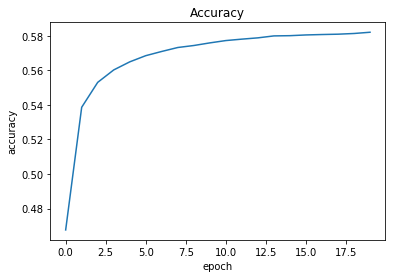

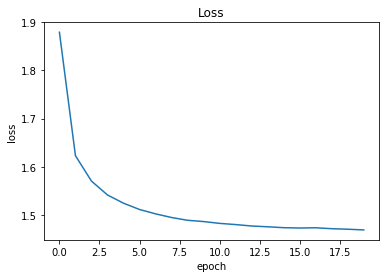

In [26]:
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

# with open("/data/My Drive/Colab Notebooks/data/text_generation_history", 'rb') as hist_file:
with open("text_generation_history", 'rb') as hist_file:
    history = pickle.load(hist_file)
    
plt.plot(history['acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# TODO Loss plotten
plt.plot(history['loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()